Joint Representation
=================

In this tutorial, we will use pre-trained topic models to create a joint representation of the the SHARE-seq dataset which embeds cells in a low-dimensional space based on both accessibility and expression modailities. The joint embedding space can be used to calculate a joint-KNN graph that better captures differentiation trajectories and cellular heterogeneity. The joint-KNN graph can be used for UMAP visualization, clustering, and pseudotime trajectory inference.

First, we need to import some packages:

In [1]:
import mira
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import logging
import seaborn as sns

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=550, frameon = False, legend_fontsize=12
)

Next we load data:

In [2]:
rna_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/rna_data.h5ad')
atac_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/atac_data_raw_counts_only.h5ad')

And our topic models:

In [3]:
rna_model = mira.topics.ExpressionTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Using our models, we can predict topic compositions for our cells. The topics are a distribution over expression of genes, so cell-topic compositions represent how much different modules of gene expression are active in a cell.

The `predict` method takes the requisite AnnData objects as input and saves the topic compositions for cells and features.

In [4]:
rna_model.predict(rna_data)
atac_model.predict(atac_data)

Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:07<00:00,  7.46it/s]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
Predicting latent vars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:20<00:00,  1.18s/it]
INFO:mira.adata_interface.topic_model:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_

Next, we wish to use those cell-topic compositions as features to find cells which are in similar states. Compositions are in the simplex space, which can distort inter-cell distances. Therefor, we convert the simplical topic compositions to Real space using the *Isometric log ratio* (ILR) transformation.

The parameter `box_cox` controls the box-cox power transformation applied to the simplical data. Passing zero or "log" gives the standard ILR transformation. Passing a float less than one gives a box-cox generalization of the ILR. Larger values generally produce more complex structures in the latent space.

Additionally, the ILR transformation reduces the dimension of the simplex from K to K-1 while projecting the data to orthonormal Real space. In transformed space, the levels of features correspond to axes of multiple topics. These groups of topics can be arbitrarily chosen, or topics can be grouped together based on the similarity of the gene/peak modules they encode. 

In the MIRA paper, we use arbitrary relationships between topics, implemented by `get_umap_features`. You may also encode a latent space informed by inter-topic similarities using `get_hierarchical_umap_features`. These options produce similar results, but `get_hierarchical_umap_features` sometimes identifies finer structural details in the topic compositions.

In [5]:
rna_model.get_hierarchical_umap_features(rna_data, box_cox=0.23)
atac_model.get_hierarchical_umap_features(atac_data, box_cox=0.23)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


Let's visualize how the topics describe cell populations and variance in the dataset. We'll start by creating separate visualizations for expression and accessibility. First, we need use the embedding space to create a K-nearsest neighbors graph using `sc.pp.neighbors`. To make sure the correct embeddings are used, make sure to specify `use_rep = 'X_joint_umap_features`. Also, specify `metric = 'manhattan'` to leverage the orthonormality of ILR-transformed space to find cells in similar states.

One application of the joint-KNN graph is to calculate a 2-D UMAP view of the data. When calculating UMAPs, setting `min_dist = 0.1` highlights lineage structures and reduces the "fuzziness" of the UMAP view.

We do this for both modalities below:

In [6]:
sc.pp.neighbors(rna_data, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 21)
sc.tl.umap(rna_data, min_dist = 0.1)
sc.pp.neighbors(atac_data, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 21)
sc.tl.umap(atac_data, min_dist = 0.1)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
atac_data.obs = atac_data.obs.join(rna_data.obs.true_cell, how = 'left')
atac_data.obs.true_cell = atac_data.obs.true_cell.astype(str)

In [8]:
palette = dict(zip(
    atac_data.obs.true_cell.unique(), [sns.color_palette('Set3')[i%12] for i in range(30)]
))

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'highly_variable' as categorical
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical


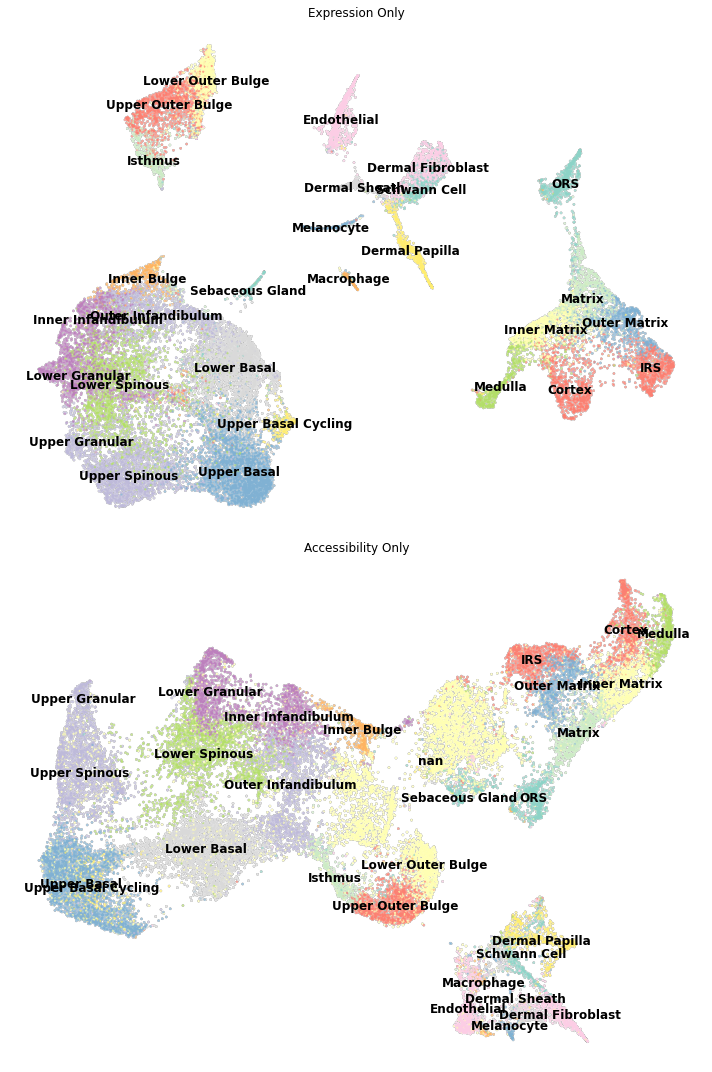

In [9]:
fig, ax = plt.subplots(2,1,figsize=(10,15))
sc.pl.umap(rna_data, color = 'true_cell', legend_loc = 'on data', ax = ax[0], size = 20,
          **umap_kwargs, title = 'Expression Only', show = False, palette=palette)

sc.pl.umap(atac_data, color = 'true_cell', legend_loc = 'on data', ax = ax[1], size = 20,
          **umap_kwargs, title = 'Accessibility Only', show = False, na_color = 'lightgrey',
          palette=palette)
plt.tight_layout()
plt.show()

Now, let's combine the modailities. We can construct the joint embedding space using [mira.utils.make_joint_representation](asdf). This function takes the two modalities' AnnDatas as input, then finds common cells, joins the separate transformed topic spaces to make the joint embedding for each cell, and returns those AnnDatas.

In [10]:
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

INFO:mira.adata_interface.utils:28429 out of 34768 cells shared between datasets (81%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


Finally, we can use the joint embedding space to create the joint-KNN graph using:

In [11]:
sc.pp.neighbors(rna_data, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 21)

And visualize the joint-KNN graph using UMAP. The UMAP view below, as analyzed thoroughly in the [MIRA paper](https://www.biorxiv.org/content/10.1101/2021.12.06.471401v1.full.pdf) reveals interesting aspects of skin differentiation biology.

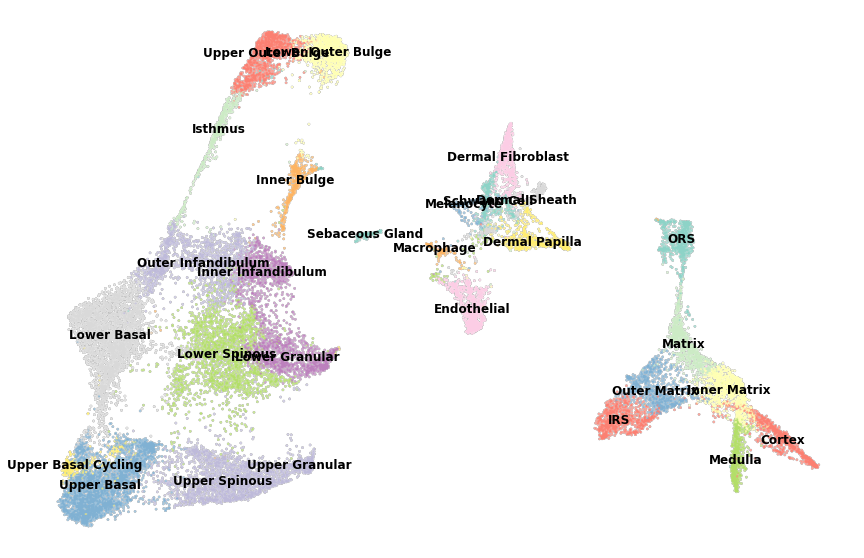

In [12]:
sc.tl.umap(rna_data, min_dist = 0.1)

fig, ax = plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(rna_data, color = 'true_cell', legend_loc = 'on data', ax = ax, size = 20,
          **umap_kwargs, title = '')

Now, let's isolate the hair follicle system and show the effects of tuning the `box_cox` parameter on the UMAP view. 

In [13]:
hair_follicle = rna_data[
    rna_data.obs.true_cell.isin(
        ['ORS','Matrix','IRS','Outer Matrix','Inner Matrix','Medulla','Cortex'])
    ]

hair_follicle_atac = atac_data[hair_follicle.obs_names]
hair_follicle_atac.obsm['X_umap'] = hair_follicle.obsm['X_umap']

Turn off logging so we aren't swamped with messages:

In [14]:
mira.adata_interface.core.logger.setLevel(logging.WARN)
mira.adata_interface.topic_model.logger.setLevel(logging.WARN)
mira.adata_interface.utils.logger.setLevel(logging.WARN)

Then iterate over some possible values for the `box_cox` parameter, colored by cell type for comparisons between plots.

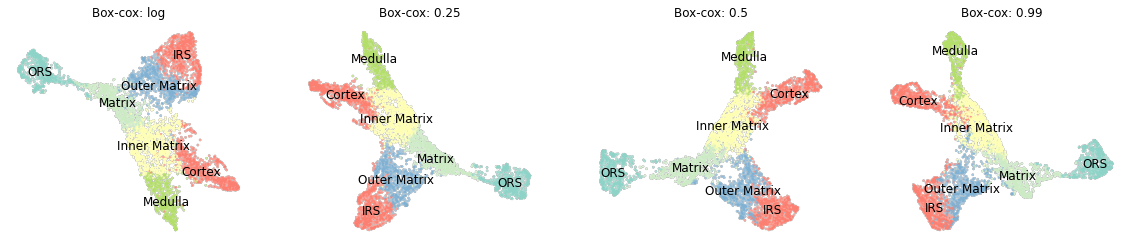

In [18]:
def boxcox_test(ax, box_cox, rna, atac):
    
    atac_model.get_umap_features(atac, box_cox=box_cox)
    rna_model.get_umap_features(rna, box_cox=box_cox)

    rna, atac = mira.utils.make_joint_representation(rna, atac)

    sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 20)
    sc.tl.umap(rna, min_dist = 0.1)
    sc.pl.umap(rna, ax = ax, show = False, title = 'Box-cox: ' + str(box_cox),
              color = 'true_cell', color_map = 'Set3', legend_loc='on data',
              add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
              legend_fontweight=150, frameon = False, legend_fontsize=12)
    
fig, ax = plt.subplots(1,4, figsize=(20,4))
for ax_i, box_cox in zip(ax, ['log',0.25,0.5,0.99]):
    boxcox_test(ax_i, box_cox, hair_follicle, hair_follicle_atac)

plt.show()

We see that as the `box_cox` parameter increases, some finer details in the manifold emerge, such as multiple paths between the *Matrix* and *IRS* cells. For the hair follicle, "log" and 0.99 hide meaningful structure in the data, so it is clear that the optimal `box_cox` transformation for this dataset is somewhere in the realm of 0.25 to 0.5. Notably, **the underlying topic compositions have not changed**, just our definition of the joint-KNN graph and our subsequent view of the it in UMAP space.

Try multiple values for `box_cox` to find a view that sufficiently demonstrates the connectivity structure of the data.

Overall, in constructing the joint representation and ensuing visual representation of the data (atleast with UMAP), there are several hyperparameters to consider:

| Parameter | Source | What it does | Good value |
| -- | -- | -- | -- |
| box_cox | MIRA | Controls box-cox power transformation of topic compositions. A value of zero/"log" performs ILR trasformation. Larger values give a box-cox generalization of ILR and generally find more complex structure in the data. | "log", 0.25, 0.5, 0.75 |
| n_neighbors | MIRA | Number of neighbors in joint-KNN graph. Greater values increase "clumpiness" of joint KNN and remove finer structures and neighborhoods | 15 |
| min_dist | UMAP | How close together can cells of similar state be placed in 2-D space. Lower values decrease "fuzziness" of UMAP. | 0.1 |
| negative_sample_rate | UMAP | Repulsive force of UMAP algorithm. Decreasing this parameter makes UMAP view more similar to force-directed layouts, where attractive forces are prioritized. | 1 - 5 |

With the joint representation made, we can investigate regulatory dynamics in these differentiation systems. Please view the next tutorial to see how MIRA's pseudotime trajectory inference enables the analysis of the hair follicle.

In [19]:
hair_follicle_atac.write_h5ad('data/tutorial_data/hair_follicle_atac.h5ad')
hair_follicle.write_h5ad('data/tutorial_data/hair_follicle.h5ad')